# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1_q0IoEbPd1O225ERsj2CCGrhygzDOPPo?usp=sharing

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
data = open('/content/drive/MyDrive/Colab Notebooks/SMSSpamCollection', 'r')

for line in data:
  if (line[0] == 's'):
    print(line)
    break

for line in data:
  if (line[0] == 'h'):
    print(line)
    break

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

ham	U dun say so early hor... U c already then say...



The spam label is "spam"

The non-spam label is "ham"

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
spam = 0
ham = 0

for line in data:
  if (line[0] == 's'):
    spam += 1

  else:
    ham += 1

print("Number of spam: " + str(spam))
print("Number of non-spam: " + str(ham))


Number of spam: 746
Number of non-spam: 4824


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantage: accounts for spelling mistakes, less computation due to less data

Disadvantage: More computation, may have lower accuracy

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
#  !pip uninstall torchtext

#  !pip install -U torchtext==0.6

In [ ]:
import torchtext
# from torchtext import data
# !pip install --upgrade torchtext

# print(torchtext.__version__)

text_field = torchtext.data.Field(sequential = True, tokenize = lambda x: x, batch_first = True, use_vocab = True, include_lengths=True)
label_field = torchtext.data.Field(sequential = False, preprocessing=lambda x: int(x == 'spam'), batch_first = True, use_vocab = False, is_target = True)

fields = [('label', label_field), ('sms', text_field)]

dataNew = torchtext.data.TabularDataset('/content/drive/MyDrive/Colab Notebooks/SMSSpamCollection', format='tsv', fields=fields, skip_header=False)

In [ ]:
# from torch.utils.data import dataset

train, val, test = dataNew.split([0.6, 0.2, 0.2], True)

print(len(train))
print(len(val))
print(len(test))

3343
1115
1114


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

The imbalance in the data could be problamatic because our model might become bias to the most common example in the messages, which is the non-spam messages. This would mean the model wouldn't be able to generalize well and could fail in real world applications

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
# text_field.vocab.stoi
# text_field.vocab.itos

text_field.vocab.stoi stands for string to integer and it maps each charecter in the train data to a integer indice

text_field.vocab.itos stands for integer to string and it's the reverse mapping of stoi. It maps each integer indice to a charecter

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

unk represent unkown characters

pad represents the padding and is used to make all strings the same size

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
i=0

for batch in train_iter:
    if i==10:
      break

    print("Batch ", i)
    print("Max length: ", int(batch.sms[1][0]))

    pad=0

    for text in batch.sms[1]:
      pad += batch.sms[1][0] - text

    print("Padding: ", int(pad))
    # print(len(batch))
    # print((batch.text).shape)
    # print(batch.text[0])
    # print(batch.text[1])
    # print((batch.label).shape)
    # print(i)
    print("\n")
    i+=1


Batch  0
Max length:  142
Padding:  35


Batch  1
Max length:  154
Padding:  0


Batch  2
Max length:  66
Padding:  37


Batch  3
Max length:  45
Padding:  37


Batch  4
Max length:  42
Padding:  33


Batch  5
Max length:  161
Padding:  0


Batch  6
Max length:  146
Padding:  28


Batch  7
Max length:  156
Padding:  0


Batch  8
Max length:  115
Padding:  46


Batch  9
Max length:  26
Padding:  4




## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class RNN(nn.Module):
    def __init__(self, hidden_size):
        super(RNN, self).__init__()
        self.name = "rnn"
        self.emb = torch.eye(len(text_field.vocab.itos))
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(len(text_field.vocab.itos), hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.emb[x]
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """

    correct, total = 0, 0
    for item in data:
        msg = item.sms
        labels = item.label
        output = model(msg[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

# test_loader = TweetBatcher(test, batch_size=64, drop_last=False)


### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [ ]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss, valid_loss, train_acc, valid_acc = [], [], [], []
    epochs = []

    start_time = time.time()
    for epoch in range(num_epochs):
        for item in train:
            msg = item.sms
            labels = item.label
            optimizer.zero_grad()
            pred = model(msg[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        train_loss.append(float(loss))

        for item in valid:
            msg = item.sms
            labels = item.label
            pred = model(msg[0])
            loss = criterion(pred, labels)
        valid_loss.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))

        # print("Epoch %d: Loss %f: Train Acc %f: Val Acc %f" % (
        #       epoch+1, loss, train_acc[-1], valid_acc[-1]))
        print(("Epoch {}: Train acc: {:.4}, Train loss: {:.4} | Validation acc: {:.4}, Validation loss: {:.4}").format(
            epoch + 1,
            train_acc[epoch],
            train_loss[epoch],
            valid_acc[epoch],
            valid_loss[epoch]))

    # plotting
    plt.title("Training Curve")
    plt.plot(train_loss, label="Train")
    plt.plot(valid_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
valid_iter = torchtext.data.BucketIterator(val,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

Epoch 1: Train acc: 0.6808, Train loss: 0.6648 | Validation acc: 0.7605, Validation loss: 0.651
Epoch 2: Train acc: 0.9128, Train loss: 0.3867 | Validation acc: 0.9229, Validation loss: 0.252
Epoch 3: Train acc: 0.9183, Train loss: 0.1742 | Validation acc: 0.9309, Validation loss: 0.125
Epoch 4: Train acc: 0.9274, Train loss: 0.2272 | Validation acc: 0.9309, Validation loss: 0.2461
Epoch 5: Train acc: 0.9096, Train loss: 0.5378 | Validation acc: 0.9561, Validation loss: 0.2449


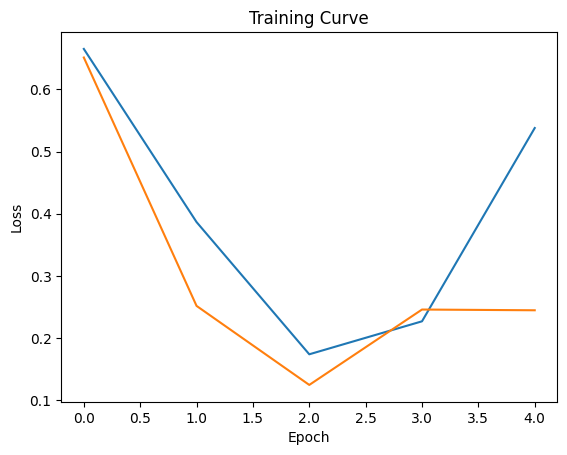

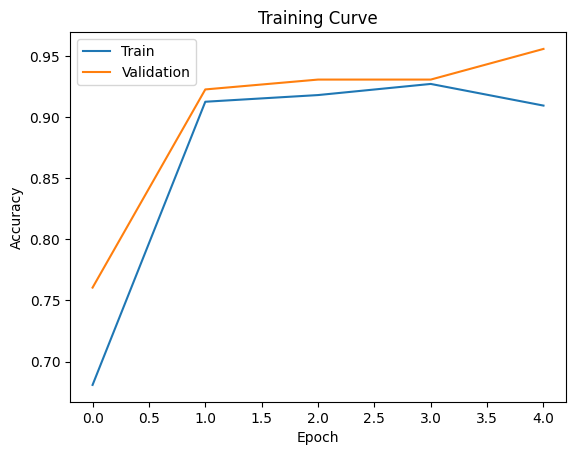

In [ ]:
# train using values that are arbitrarily chosen

model = RNN(50)
train_rnn_network(model, train_iter, valid_iter, num_epochs=5, learning_rate=2e-4)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Chose hyperparameter: (Number of epochs, learning rate, model architecture, hidden layer size)

Epoch 1: Train acc: 0.6642, Train loss: 0.6717 | Validation acc: 0.7578, Validation loss: 0.6415
Epoch 2: Train acc: 0.7697, Train loss: 0.5936 | Validation acc: 0.7749, Validation loss: 0.6209
Epoch 3: Train acc: 0.8773, Train loss: 0.3735 | Validation acc: 0.9399, Validation loss: 0.3872
Epoch 4: Train acc: 0.9033, Train loss: 0.2469 | Validation acc: 0.9426, Validation loss: 0.1378
Epoch 5: Train acc: 0.9131, Train loss: 0.1652 | Validation acc: 0.9444, Validation loss: 0.1618
Epoch 6: Train acc: 0.9241, Train loss: 0.2194 | Validation acc: 0.9417, Validation loss: 0.2007
Epoch 7: Train acc: 0.9284, Train loss: 0.1498 | Validation acc: 0.9417, Validation loss: 0.2032
Epoch 8: Train acc: 0.9265, Train loss: 0.1298 | Validation acc: 0.9471, Validation loss: 0.09667
Epoch 9: Train acc: 0.9357, Train loss: 0.3344 | Validation acc: 0.9247, Validation loss: 0.2918
Epoch 10: Train acc: 0.5351, Train loss: 1.251 | Validation acc: 0.1659, Validation loss: 1.065
Epoch 11: Train acc: 0.8635, T

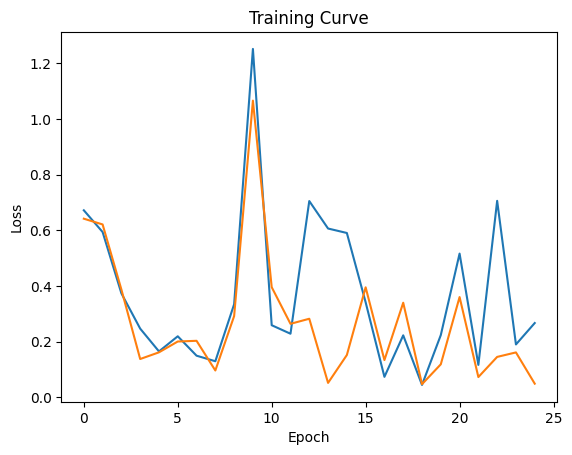

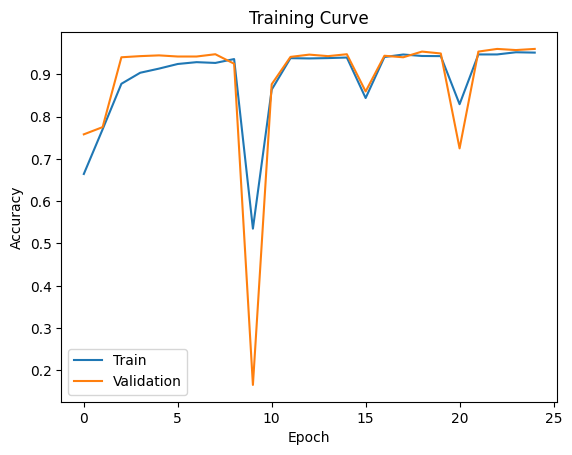

In [ ]:
# increase the number of epochs to allow more time to learn
# decrease learning rate to prevent overfitting

model1 = RNN(50)
train_rnn_network(model1, train_iter, valid_iter, num_epochs=25, learning_rate=1e-4)

In [ ]:
class MaxPoolingRNN(nn.Module):
    def __init__(self, hidden_size):
        super(MaxPoolingRNN, self).__init__()
        self.name = "rnn"
        self.emb = torch.eye(len(text_field.vocab.itos))
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(len(text_field.vocab.itos), hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.emb[x]
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(torch.max(out, dim=1)[0])
        return out

Epoch 1: Train acc: 0.6803, Train loss: 0.6884 | Validation acc: 0.4422, Validation loss: 0.6967
Epoch 2: Train acc: 0.9007, Train loss: 0.6463 | Validation acc: 0.8404, Validation loss: 0.5997
Epoch 3: Train acc: 0.9241, Train loss: 0.3968 | Validation acc: 0.9605, Validation loss: 0.5232
Epoch 4: Train acc: 0.9174, Train loss: 0.3478 | Validation acc: 0.9543, Validation loss: 0.3147
Epoch 5: Train acc: 0.9391, Train loss: 0.3593 | Validation acc: 0.9471, Validation loss: 0.3749
Epoch 6: Train acc: 0.9062, Train loss: 0.1178 | Validation acc: 0.9713, Validation loss: 0.2385
Epoch 7: Train acc: 0.941, Train loss: 0.061 | Validation acc: 0.9596, Validation loss: 0.2039
Epoch 8: Train acc: 0.9494, Train loss: 0.3181 | Validation acc: 0.9677, Validation loss: 0.1787
Epoch 9: Train acc: 0.5956, Train loss: 0.1167 | Validation acc: 0.8924, Validation loss: 0.12
Epoch 10: Train acc: 0.6641, Train loss: 0.5975 | Validation acc: 0.9022, Validation loss: 0.34
Epoch 11: Train acc: 0.8392, Train 

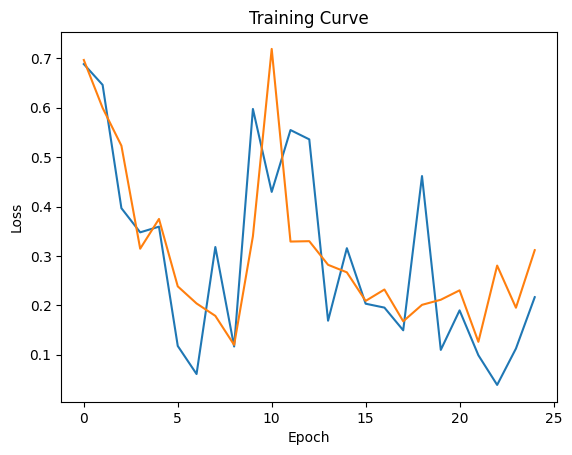

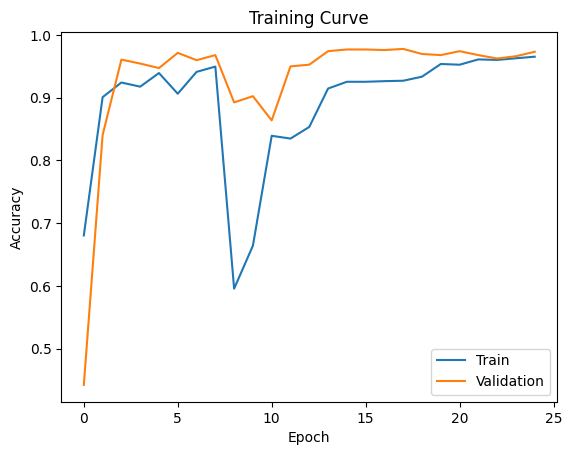

In [ ]:
# Change the model arhitecure to incorporate max pooling over output array
# Increase the hidden units of the model
# this will increase the models complexity, this is why we keep the epochs the same and increase lr
model2 = MaxPoolingRNN(75)
train_rnn_network(model2, train_iter, valid_iter, num_epochs=25, learning_rate=1e-4)

In [ ]:
class AveragePoolingRNN(nn.Module):
    def __init__(self, hidden_size):
        super(AveragePoolingRNN, self).__init__()
        self.name = "rnn"
        self.emb = torch.eye(len(text_field.vocab.itos))
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(len(text_field.vocab.itos), hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, 2)

    def forward(self, x):
        x = self.emb[x]
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
        return self.fc(out)

Epoch 1: Train acc: 0.7624, Train loss: 0.6824 | Validation acc: 0.8215, Validation loss: 0.689
Epoch 2: Train acc: 0.5865, Train loss: 0.6328 | Validation acc: 0.2843, Validation loss: 0.698
Epoch 3: Train acc: 0.5982, Train loss: 0.6705 | Validation acc: 0.3013, Validation loss: 0.7007
Epoch 4: Train acc: 0.9042, Train loss: 0.5083 | Validation acc: 0.9543, Validation loss: 0.5243
Epoch 5: Train acc: 0.9221, Train loss: 0.3992 | Validation acc: 0.9399, Validation loss: 0.513
Epoch 6: Train acc: 0.9139, Train loss: 0.289 | Validation acc: 0.9462, Validation loss: 0.3161
Epoch 7: Train acc: 0.9264, Train loss: 0.2788 | Validation acc: 0.9507, Validation loss: 0.3122
Epoch 8: Train acc: 0.9441, Train loss: 0.3318 | Validation acc: 0.9507, Validation loss: 0.211
Epoch 9: Train acc: 0.9498, Train loss: 0.3384 | Validation acc: 0.9471, Validation loss: 0.2051
Epoch 10: Train acc: 0.9531, Train loss: 0.1254 | Validation acc: 0.9552, Validation loss: 0.2189
Epoch 11: Train acc: 0.9517, Train

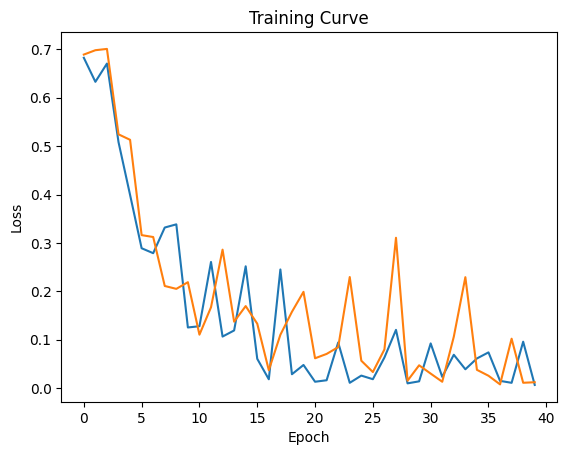

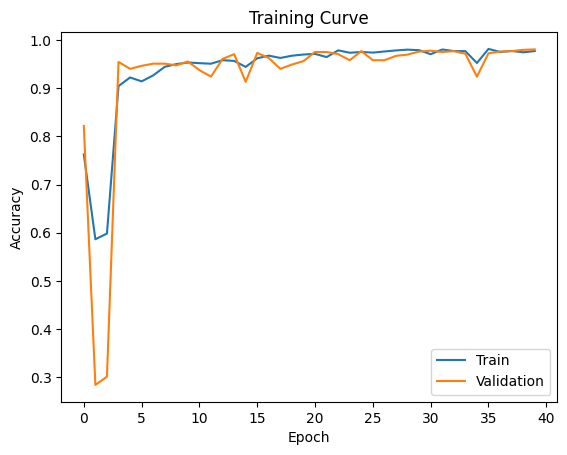

In [ ]:
# Change the model arhitecure to incorporate max pooling and average over output array
# Increase the number of epochs to allow more time to learn the data

model3 = AveragePoolingRNN(50)
train_rnn_network(model3, train_iter, valid_iter, num_epochs=40, learning_rate=1e-4)

Epoch 1: Train acc: 0.5245, Train loss: 0.6708 | Validation acc: 0.1471, Validation loss: 0.7328
Epoch 2: Train acc: 0.8541, Train loss: 0.2969 | Validation acc: 0.948, Validation loss: 0.4717
Epoch 3: Train acc: 0.8014, Train loss: 0.354 | Validation acc: 0.9417, Validation loss: 0.2184
Epoch 4: Train acc: 0.937, Train loss: 0.2536 | Validation acc: 0.9587, Validation loss: 0.2904
Epoch 5: Train acc: 0.9489, Train loss: 0.3695 | Validation acc: 0.9534, Validation loss: 0.4102
Epoch 6: Train acc: 0.9534, Train loss: 0.1234 | Validation acc: 0.9534, Validation loss: 0.2468
Epoch 7: Train acc: 0.9509, Train loss: 0.09372 | Validation acc: 0.9381, Validation loss: 0.2392
Epoch 8: Train acc: 0.9567, Train loss: 0.1566 | Validation acc: 0.9471, Validation loss: 0.1421
Epoch 9: Train acc: 0.9474, Train loss: 0.4534 | Validation acc: 0.965, Validation loss: 0.05736
Epoch 10: Train acc: 0.963, Train loss: 0.08233 | Validation acc: 0.9614, Validation loss: 0.0613
Epoch 11: Train acc: 0.9678, Tr

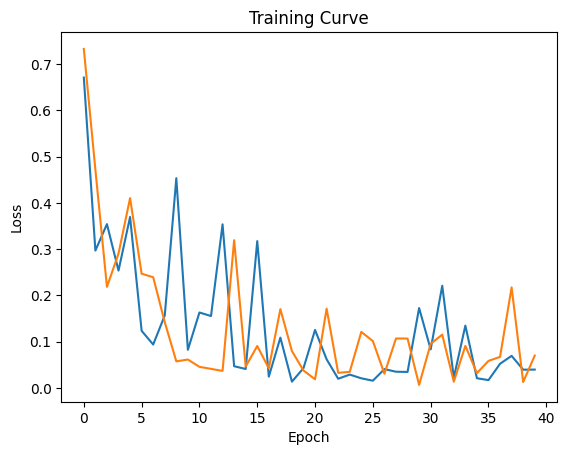

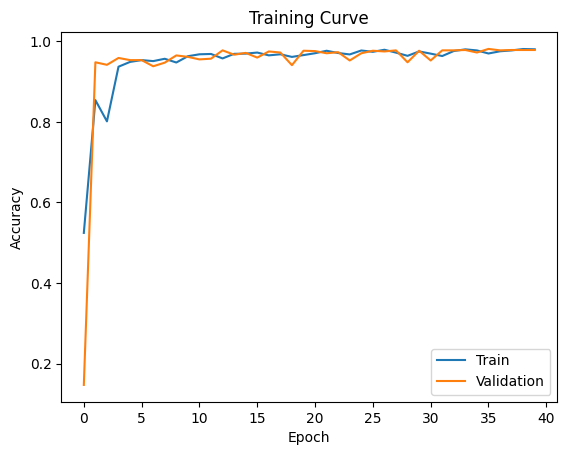

In [ ]:
# increase the number of hidden layers and epochs to increase accuracy
model4 = AveragePoolingRNN(75)
train_rnn_network(model4, train_iter, valid_iter, num_epochs=40, learning_rate=1e-4)

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in val.examples if e.label == 1],
    val.fields)

# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in val.examples if e.label == 0],
    val.fields)

valid_spam_data = torchtext.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

valid_nospam_data = torchtext.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

spam_acc = 1 - get_accuracy(model3, valid_spam_data)
nospam_acc = 1 - get_accuracy(model3, valid_nospam_data)

print("Spam Acc: ", 1-spam_acc)
print("Non-Spam Acc: ", 1-nospam_acc)

Spam Acc:  0.94
Non-Spam Acc:  0.9844559585492227


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

high false postive means theres a high chance that non spam messages would be marked as spam. High false negatives would mean spam messages wouldnt be marked as spam

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
test_iter = torchtext.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

test_acc = get_accuracy(model3, test_iter)
print("Test Acc:", test_acc)

Test Acc: 0.9748653500897666


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)

# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

test_spam_data = torchtext.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

test_nospam_data = torchtext.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

spam_acc = 1 - get_accuracy(model3, valid_spam_data)
nospam_acc = 1 - get_accuracy(model3, valid_nospam_data)

print("Spam Acc: ", 1-spam_acc)
print("Non-Spam Acc: ", 1-nospam_acc)

Spam Acc:  0.94
Non-Spam Acc:  0.9854922279792746


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"
stoi = []

for i in range(len(msg)):
    stoi.append(text_field.vocab.stoi[msg[i]])

test_msg = torch.LongTensor(stoi).unsqueeze(dim=0)
pred = model3(test_msg)
prob = F.softmax(pred, dim=1)

print(float(prob[0][1]))

0.022641712799668312


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

It was not too hard building a model to detect spam, and the model I built had a high training accuracy and testing accuracy. A simple baseline model would be taking the most common words that appear in spam messages and labeling messages that have those as spam.